In [1]:
%run forward_dynamics_example.ipynb
%run pid_controller.ipynb

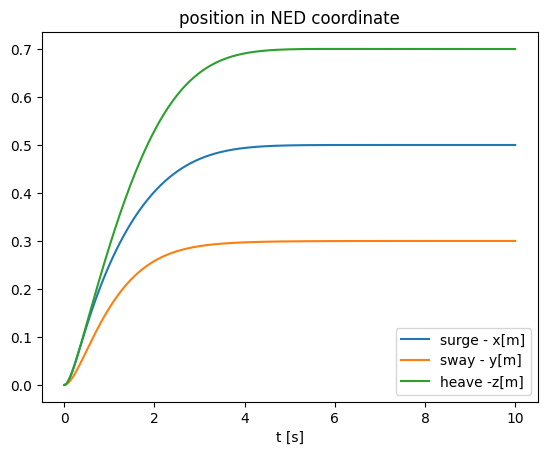

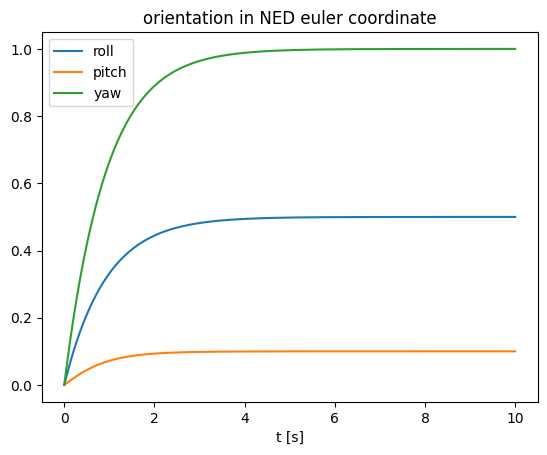

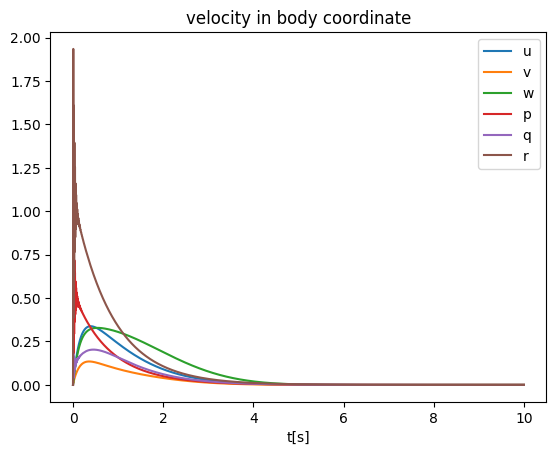

In [4]:
cl_sys = Function('cl_system', [Kp, Kd, xS0, nd, dt, v_c], [
                  F(xS0, pd_control_F_simpli, dt, v_c)])

cl_sys_fun = Function('cl_system', [xS0],
                      [cl_sys(np.array([90, 90, 90, 90, 90, 90]),
                              np.array([80.0, 80.0, 80.0, 80.0, 80.0, 80.0]), xS0,
                              np.array([0.5, 0.3, 0.7, 0.5, 0.1, 1.0]), T/N,
                              np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))])

cl_sim = cl_sys_fun.mapaccum(N)

x0 = np.array([0.0, 0.0, 0.0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #x y z w xq yq zq u v w p q r
res = cl_sim(x0)
res.T

t = np.linspace(0, T, N+1)

# Create a figure and plot the data
plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((13,1)), res.toarray()), axis=1)[0:3,:].T)
plt.legend(['surge - x[m]', 'sway - y[m]', 'heave -z[m]'])
plt.title("position in NED coordinate")
plt.xlabel('t [s]')

plt.figure()
vfunc = np.vectorize(euler_from_quaternion, signature='(n)->(k)')
rpy_array = vfunc(np.concatenate((np.array(x0).reshape((13,1)), res.toarray()), axis=1)[3:7,:].T)
plt.plot(t, rpy_array)
plt.legend(['roll', 'pitch', 'yaw'])
plt.title("orientation in NED euler coordinate")
plt.xlabel('t [s]')

plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((13,1)), res.toarray()), axis=1)[7::,:].T)
plt.legend(['u', 'v', 'w', 'p', 'q', 'r'])
plt.xlabel('t[s]')
plt.title("velocity in body coordinate")
plt.show()